# KMEANS, DBSCAN和AP聚类
DBSCAN原理：https://www.youtube.com/watch?v=RDZUdRSDOok

再回到聚类，聚类有两类：分层和分区

分层算法递归地将数据集分割成更小的子集，直到子集仅包含一项。 这一过程可以用树状图来表示。 它可以从叶子到根（凝聚方法）或从根到叶子（分裂方法）构建。 在层次聚类中，不必指定簇的数量，但必须定义分裂/合并过程的终止条件。

分区算法根据给定的标准将数据集划分为多个子集（簇）。 对于某些算法，簇的数量必须预先定义（例如 K-Means），而对于某些算法则不需要（DBSCAN）。 在运行算法之前定义簇的数量通常需要特定的领域知识，这在许多应用程序中通常具有挑战性（甚至是不可能的）。 这导致了许多启发式方法和简化方法的发展

本文kaggle链接：https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap

## 阅读数据


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# matplotlib
# seaborn

# plotly

# numpy
# pandas
# scipy



print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.5.3
numpy version: 1.24.3
seaborn version: 0.12.2


In [2]:
import os
for dirname, _, filenames in os.walk('.\datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# 任何在这个工程文件夹的datasets子文件夹中的文件将被输出

#忽略警告
import warnings
warnings.filterwarnings('ignore')

.\datasets\data.xlsx
.\datasets\iris.csv
.\datasets\Live.csv
.\datasets\Mall_Customers.csv
.\datasets\users.xlsx
.\datasets\users_2.xlsx


In [3]:
mall_data = pd.read_csv('.\datasets\Mall_Customers.csv')

print(mall_data.shape)
print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

(200, 5)
There are 200 rows and 5 columns in our dataset.


In [4]:
mall_data.head

<bound method NDFrame.head of      CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196  Female   35                 120                      79
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83

[200 rows x 5 columns]>

In [5]:
mall_data.info()
mall_data.isnull().sum()
# 数据集完整，注意Gender代表性别，需要进行转化
# 由于数据集完整，不需要进行删除操作

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
mall_data.sample(10)

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
154         155  Female   47                  78                      16
141         142    Male   32                  75                      93
151         152    Male   39                  78                      88
1             2    Male   21                  15                      81
40           41  Female   65                  38                      35
107         108    Male   54                  63                      46
135         136  Female   29                  73                      88
191         192  Female   32                 103                      69
123         124    Male   39                  69                      91
158         159    Male   34                  78                       1

In [7]:
mall_data.describe()

CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

### 性别信息：是否要二进制？
这里我们有非数值类型的gender信息，一个简单的想法是将其转换成0-1编码，但是作者并不推荐这么做：

There is one binary, categorical column: gender. You may be tempted to one-hot encode it for the clustering. It is:

1. technically possible
2. theoretically not forbidden
3. practically not recommended

However, it is not recommended and nicely explained on the IBM support site：https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided


## 数据分析
现在主要是做一些分布上和相关性上的工作

### 分布


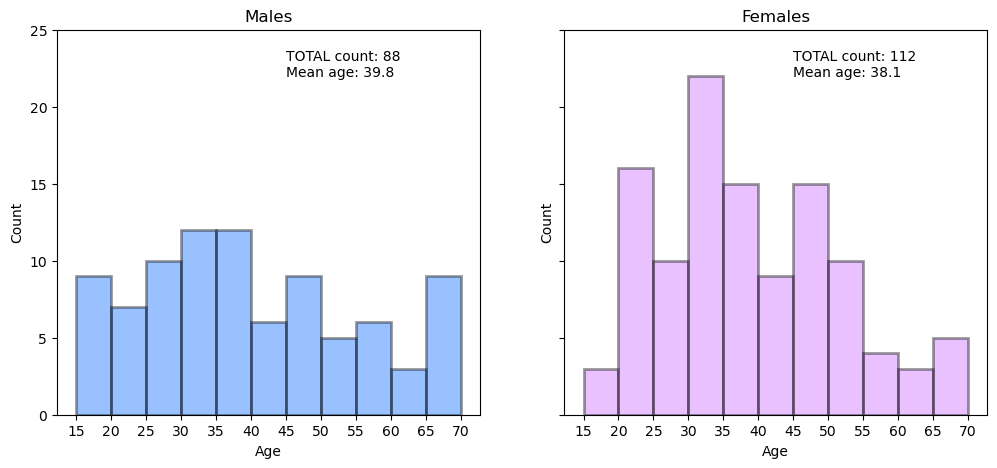

In [8]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
#使用seaborn的distplot绘制直方图，kde=False只绘制直方柱，k表示边缘颜色为黑色

ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

### Kolmogorov-Smirnov检验
https://www.bilibili.com/video/BV1gY4y1e79V/?spm_id_from=333.337.search-card.all.click&vd_source=4bccf0bae6366f8cf252ccd21d3e6844

原理是假设两个样本来自同一分布，求出P-value，其值越小，则能说明其来自不同的分布，值越大，则说明来自同一分布的概率较大

一般来说，p值若>0.05，接受原假设即样本来自的总体分布服从某指定分布无显著性差异

In [9]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


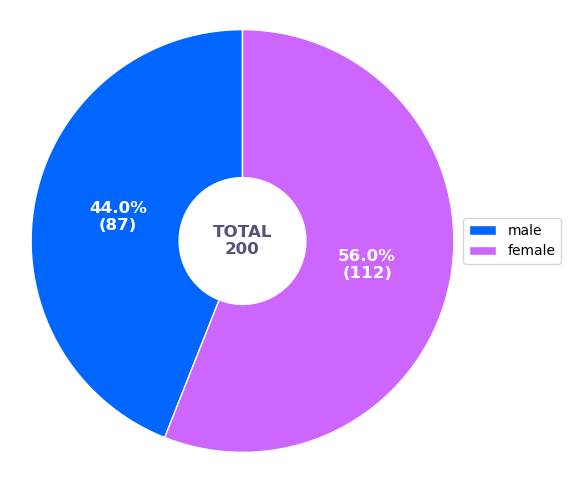

In [10]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

可以看到，男性人数比女性人数稍多

接下来我们看看两种群体的收入和箱线图

四分位数的计算：https://www.bilibili.com/video/BV1P34y1U7jB/?spm_id_from=333.788.recommend_more_video.0&vd_source=4bccf0bae6366f8cf252ccd21d3e6844

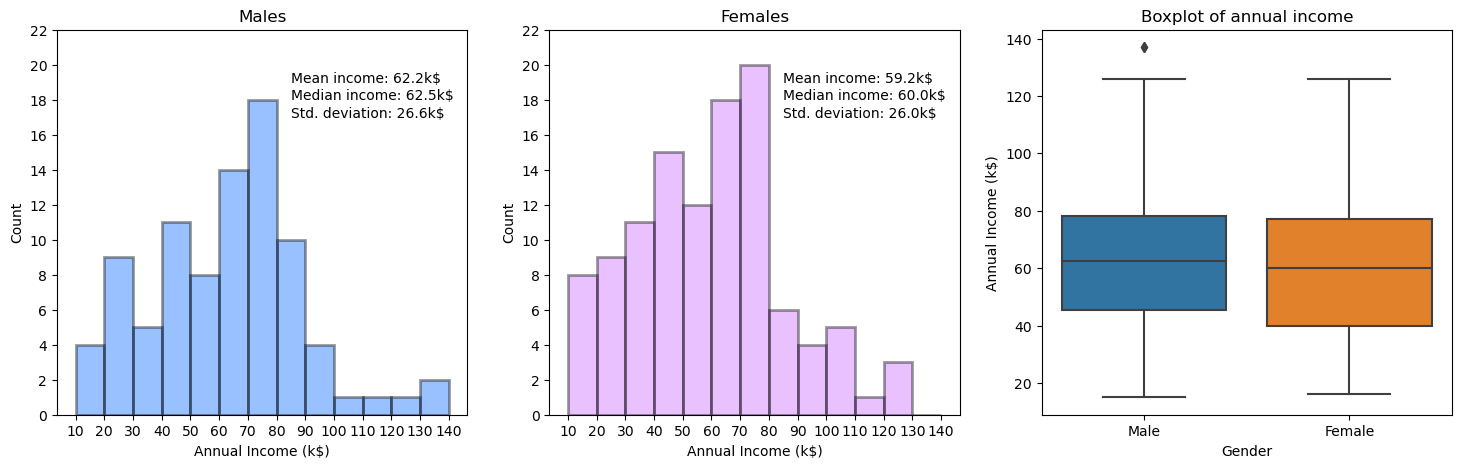

Kolgomorov-Smirnov test p-value: 0.78


In [11]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()


print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

男性平均收入高于女性（62.2 k$ vs. 59.2k\$）。 此外，男性顾客的收入中位数（6.25 万美元）也高于女性顾客（6 万美元）。 两组的标准差相似。 年收入14万美元左右的男性群体中有一个异常值。 K-S检验显示这两组没有统计学差异。

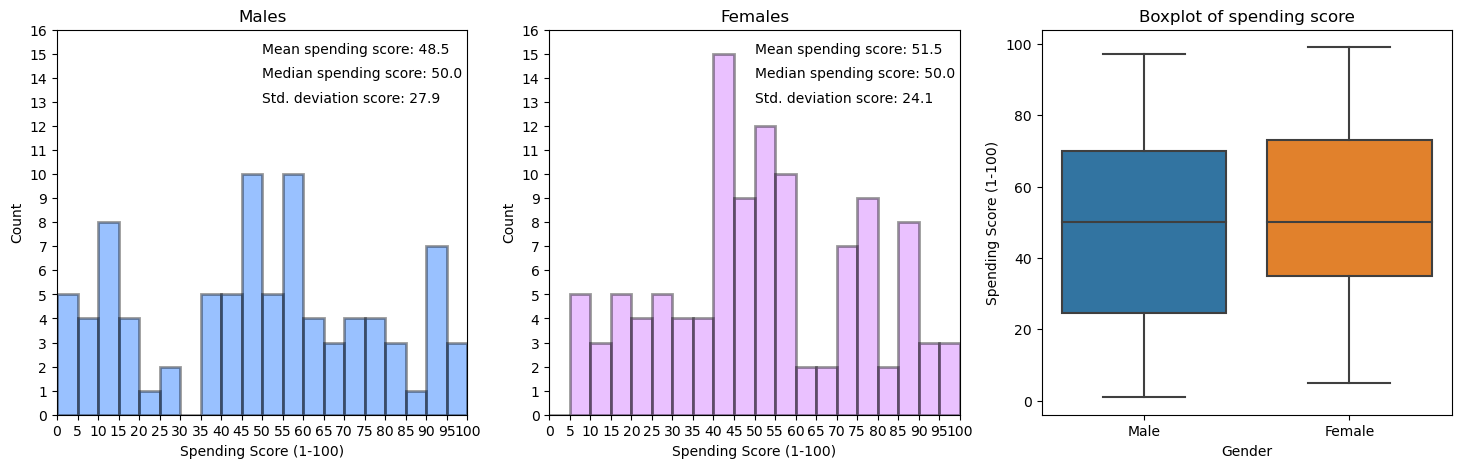

Kolgomorov-Smirnov test p-value: 0.29


In [12]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))


女性的平均支出得分 (51.5) 高于男性 (48.5)。 K-S 检验 p 值表明没有证据拒绝原假设，但证据并不像之前的比较中那么有力。 接下来将计算所有年龄段的收入中位数。为了方便理解，将代码进行分解

In [13]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
#这段代码中将data进行groupby，以gender和年龄段进行分层，年龄段的分层方式使用了pd.cut函数
# 前文中age_bins = range(15,75,5)
medians_by_age_group.head()

CustomerID   Age  Annual Income (k$)  Spending Score (1-100)
Gender Age                                                                   
Female (15, 20]       112.0  19.0                63.0                    50.0
       (20, 25]        46.0  23.0                39.0                    65.0
       (25, 30]       139.5  29.0                74.5                    73.0
       (30, 35]       126.0  32.0                70.0                    69.0
       (35, 40]       138.5  38.0                73.5                    41.0

In [14]:
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.head()

CustomerID   Age  Annual Income (k$)  Spending Score (1-100)
Gender Age_group                                                              
Female (15, 20]        112.0  19.0                63.0                    50.0
       (20, 25]         46.0  23.0                39.0                    65.0
       (25, 30]        139.5  29.0                74.5                    73.0
       (30, 35]        126.0  32.0                70.0                    69.0
       (35, 40]        138.5  38.0                73.5                    41.0

In [15]:
medians_by_age_group.reset_index(inplace=True)
# 去掉分组标志

medians_by_age_group.head()

Gender Age_group  CustomerID   Age  Annual Income (k$)  \
0  Female  (15, 20]       112.0  19.0                63.0   
1  Female  (20, 25]        46.0  23.0                39.0   
2  Female  (25, 30]       139.5  29.0                74.5   
3  Female  (30, 35]       126.0  32.0                70.0   
4  Female  (35, 40]       138.5  38.0                73.5   

   Spending Score (1-100)  
0                    50.0  
1                    65.0  
2                    73.0  
3                    69.0  
4                    41.0

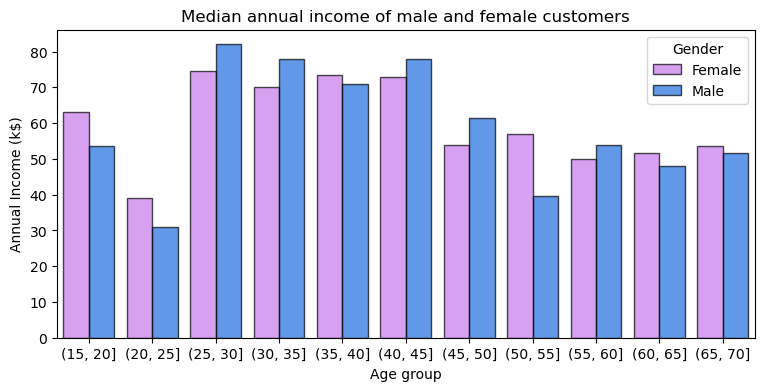

In [16]:
fig, ax = plt.subplots(figsize=(9,4))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

上面的条形图显示，最富有的客户年龄在 25-45 岁之间。 女性和男性之间最大的差异体现在 25-30 岁（男性更富有）和 50-55 岁（女性更富有）的年龄段。

## 相关性分析

Pearson相关系数：https://www.zhihu.com/question/19734616/answer/117730676

seaborn的双变量图画法（挺有用的）：https://blog.csdn.net/zyb228/article/details/101939534

seaborn的implot（回归图）画法：https://blog.csdn.net/qq_39949963/article/details/80773588

In [17]:
mall_data.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

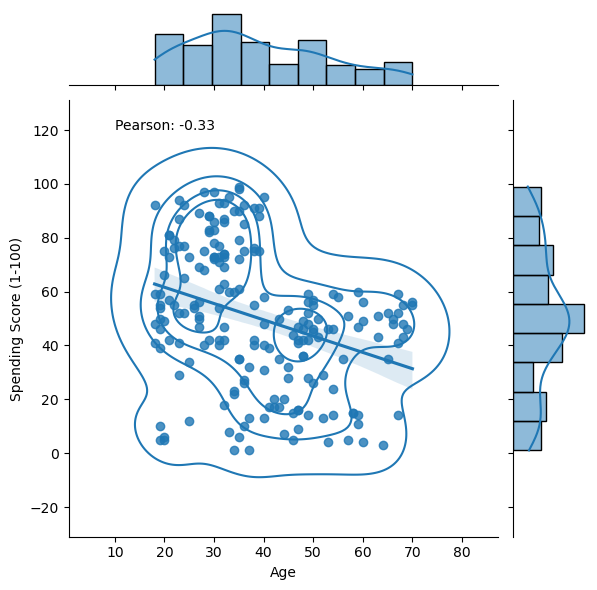

In [18]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot(x='Age', y='Spending Score (1-100)', data=mall_data, kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=5)
# 这里是一个双变量图，n_levels指的是密度曲线的个数

plt.text(10,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

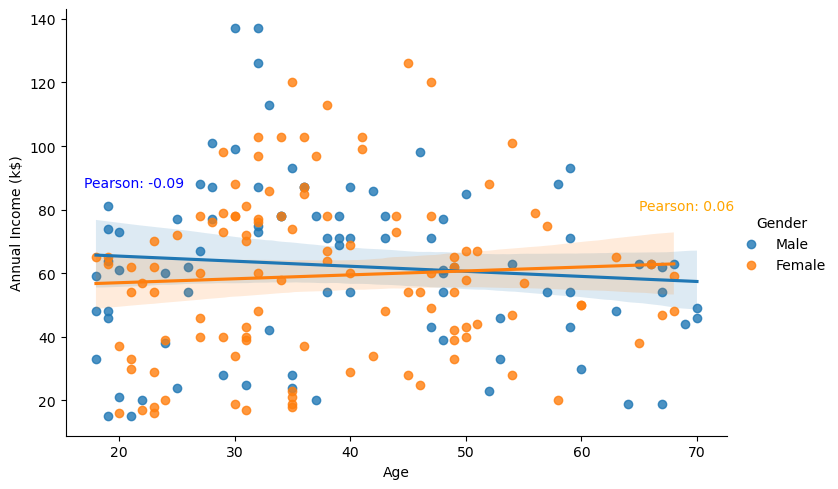

In [19]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(x='Age', y='Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(17,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

上图得到的结论是，两种性别的年龄与年收入基本上没上关联

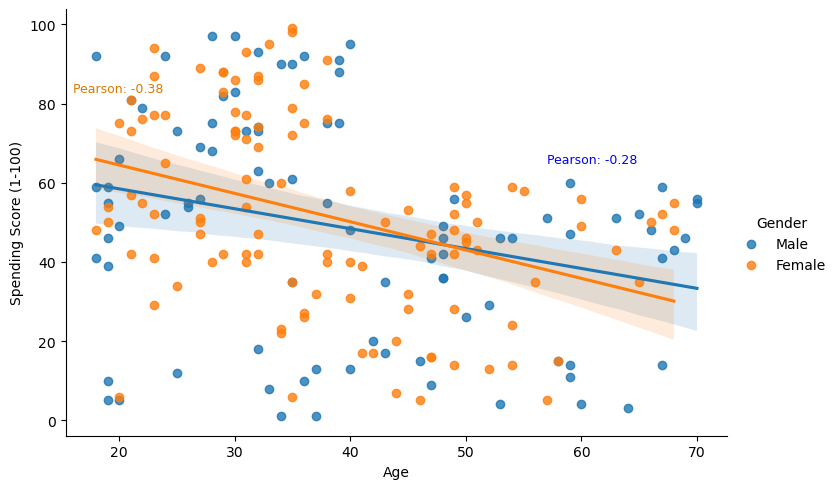

In [20]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot(x='Age', y='Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(57,65, 'Pearson: {:.2f}'.format(corr1), color='blue',fontsize=9)
plt.text(16,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900',fontsize=9)

plt.show()

结论是，消费分数与两种不同性别的客户的年龄之间存在弱关联（Pearson系数<0.5）

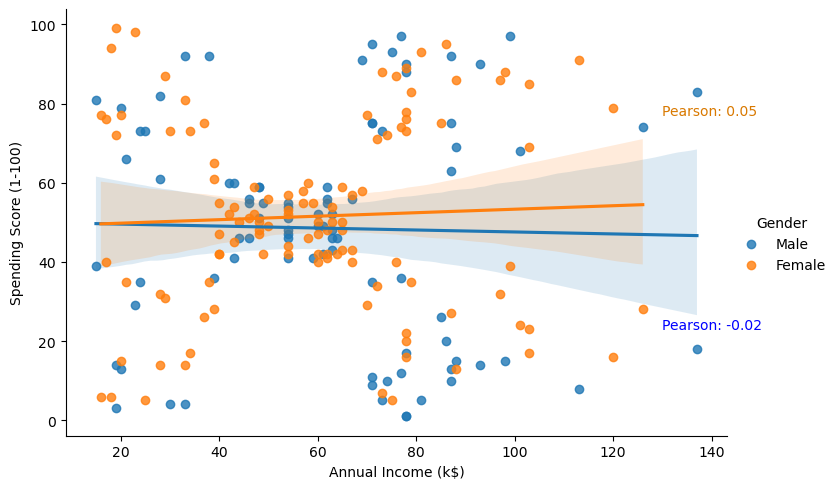

In [21]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

消费分数与不同性别的客户的年收入几乎没有关联

# 聚类


## K-Means

三个基本步骤：
1. 使用种子点将样本分成初始组。 距离这些种子点最近的样本将创建初始簇。
2. 计算样本到组中心点（质心）的距离，并将最近的样本分配给它们的集群。
3. 计算新创建（更新）的簇质心。

然后重复步骤2和3，直到算法收敛

三个主要参数：
1. 初始化标准（指的是种子点的生成，在不同的准则中，k-means++比较巧妙）
2. 聚类数
3. 距离的度量方式（一般欧式距离，如果用的是scikit则不需要用这个）


In [22]:
## 导库

from sklearn.cluster import KMeans

In [23]:
## 导入数值列，前文中说了不推荐使用二元信息，因此没有使用性别

X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

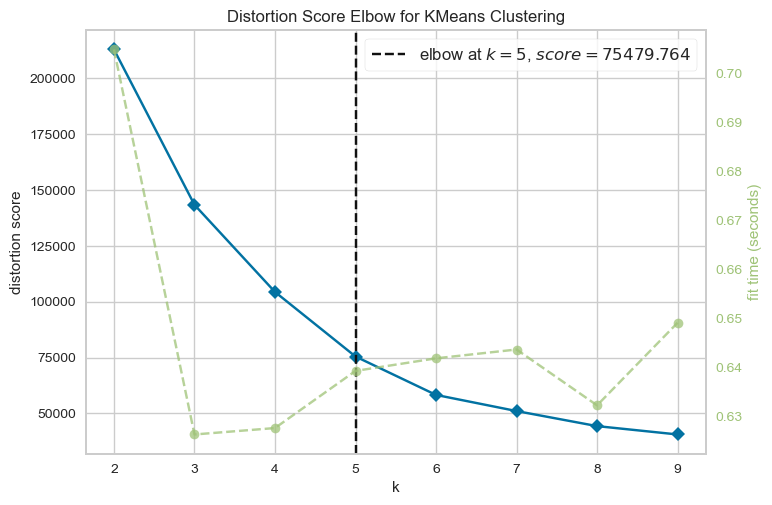

In [24]:
## 肘部法则

# yellowbrick

from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

# 下图中表示随着k增加，失真分数降低，底层算法推荐的是k=5为最佳

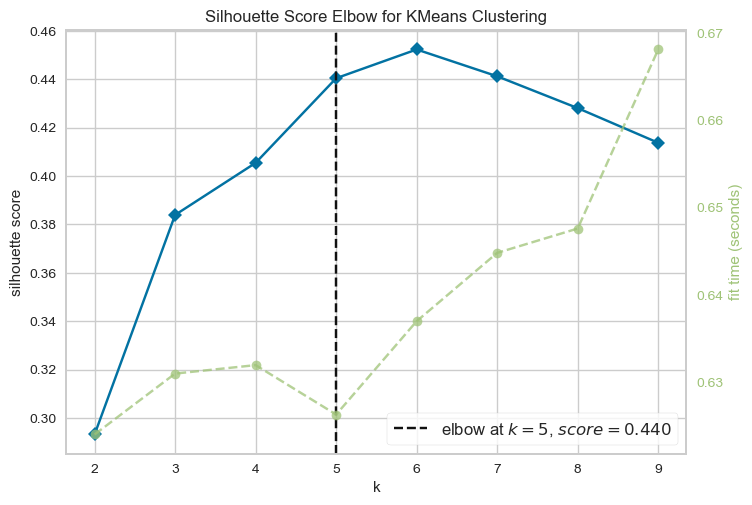

In [25]:
## 轮廓系数

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

#结果同样推荐使用k=5

### 使用K=5进行聚类

In [26]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # 初始化模型

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # 给每个样本上标签

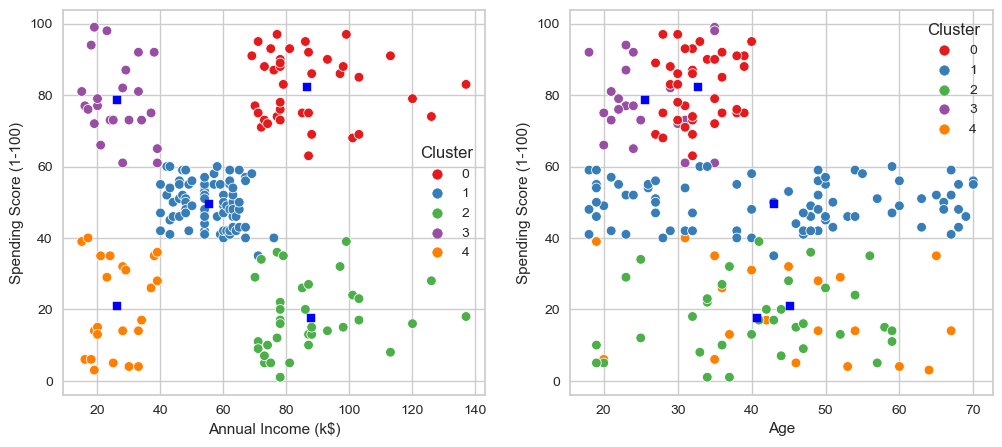

In [27]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means 算法生成以下 5 个簇：

1. 年收入低、消费评分高的客户
2. 中等年收入和中等支出分数的客户
3. 年收入高、消费评分低的客户
4. 年收入高、消费评分高的客户
5. 年收入低、消费评分低的客户

就顾客年龄而言，没有明显的群体。

In [28]:
## 各个聚类的数量

KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

KM_size
Cluster         
0             39
1             79
2             36
3             23
4             23

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

## 生成3D图像

<Figure size 700x700 with 0 Axes>

In [30]:
## 使用plotly生成3D可交互式图表

import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### 轮廓系数图

为了检验我们聚类的质量，可以使用轮廓系数图（Silhuette plot）

轮廓系数图的看法是https://blog.51cto.com/u_16099196/6439665

其实简单来说，纵轴就是一个个样本点，横轴的分数代表了这个样本点和该类的匹配度，如果以平均轮廓系数为一条分界线，在这条线右边的点是很匹配这个聚类而不匹配其他聚类的，左边的点则是相对来说更匹配其他聚类的点，从结果上看，聚类1和聚类4的点划分效果比较好

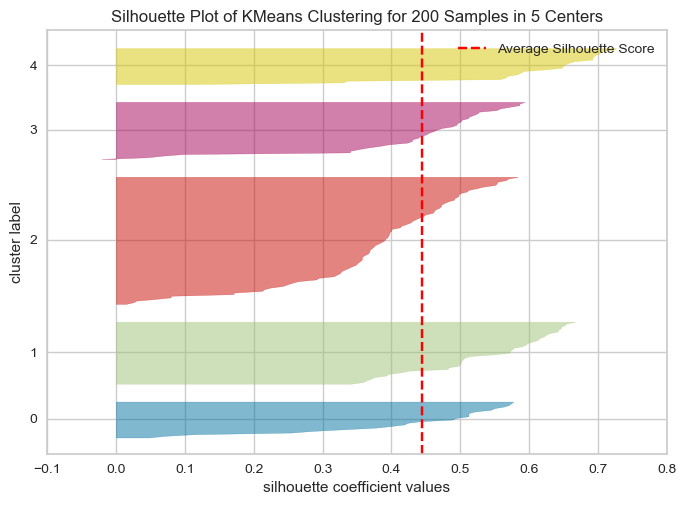

In [31]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

# DBSCAN
这个是基于密度的聚类方法，其接受两个参数：距离和一定距离内的最小点数，具体可以看之前的youtube视频

其优缺点：

## 优点
1. 能根据两个参数自动选择簇的数量
2. 能跟区分细长的簇和被其他簇包围的簇
3. 能找到不适合任何簇的异常值

## 缺点
1. 时间复杂度相对较高
2. 很难识别有不同密度的簇

## 使用DBSCAN
导包

In [32]:
from sklearn.cluster import DBSCAN
import numpy as np

两个参数：

- `eps`

- `min_samples`

In [33]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))
# 注意在此处，product是生成一个排列组合，我们看一下print的结果就明白了
print(DBSCAN_params)
# 其代表了一个列表，存储内容是一个个元组，包含了所有的排列

[(8.0, 3), (8.0, 4), (8.0, 5), (8.0, 6), (8.0, 7), (8.0, 8), (8.0, 9), (8.25, 3), (8.25, 4), (8.25, 5), (8.25, 6), (8.25, 7), (8.25, 8), (8.25, 9), (8.5, 3), (8.5, 4), (8.5, 5), (8.5, 6), (8.5, 7), (8.5, 8), (8.5, 9), (8.75, 3), (8.75, 4), (8.75, 5), (8.75, 6), (8.75, 7), (8.75, 8), (8.75, 9), (9.0, 3), (9.0, 4), (9.0, 5), (9.0, 6), (9.0, 7), (9.0, 8), (9.0, 9), (9.25, 3), (9.25, 4), (9.25, 5), (9.25, 6), (9.25, 7), (9.25, 8), (9.25, 9), (9.5, 3), (9.5, 4), (9.5, 5), (9.5, 6), (9.5, 7), (9.5, 8), (9.5, 9), (9.75, 3), (9.75, 4), (9.75, 5), (9.75, 6), (9.75, 7), (9.75, 8), (9.75, 9), (10.0, 3), (10.0, 4), (10.0, 5), (10.0, 6), (10.0, 7), (10.0, 8), (10.0, 9), (10.25, 3), (10.25, 4), (10.25, 5), (10.25, 6), (10.25, 7), (10.25, 8), (10.25, 9), (10.5, 3), (10.5, 4), (10.5, 5), (10.5, 6), (10.5, 7), (10.5, 8), (10.5, 9), (10.75, 3), (10.75, 4), (10.75, 5), (10.75, 6), (10.75, 7), (10.75, 8), (10.75, 9), (11.0, 3), (11.0, 4), (11.0, 5), (11.0, 6), (11.0, 7), (11.0, 8), (11.0, 9), (11.25, 3), 

接下来的一步是测试这些点，然后分别计算不同情况下的聚类数

In [34]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

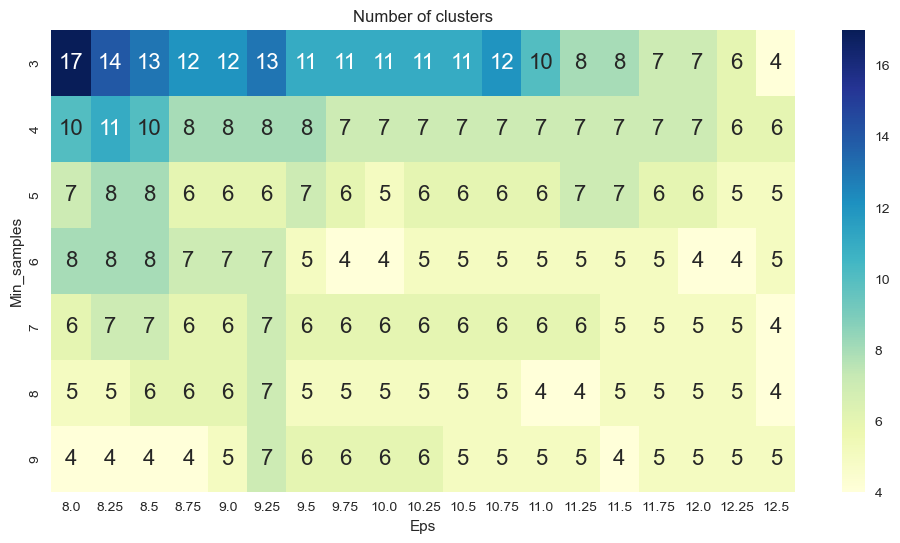

In [35]:
# 绘制一个热力图，行代表距离内最少样本数，列代表距离，然后作热力图，值使用聚类的数量，因为在上面的列表中
# 是先排序距离再排序数量，所以值直接取No_of_clusters即可

tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

上面的热图显示，簇的数量从 17 到 4 不等。但是，大多数组合给出 4-7 个簇。 为了决定选择哪种组合，我将使用一个指标 - 剪影分数，然后我将再次将其绘制为热图。

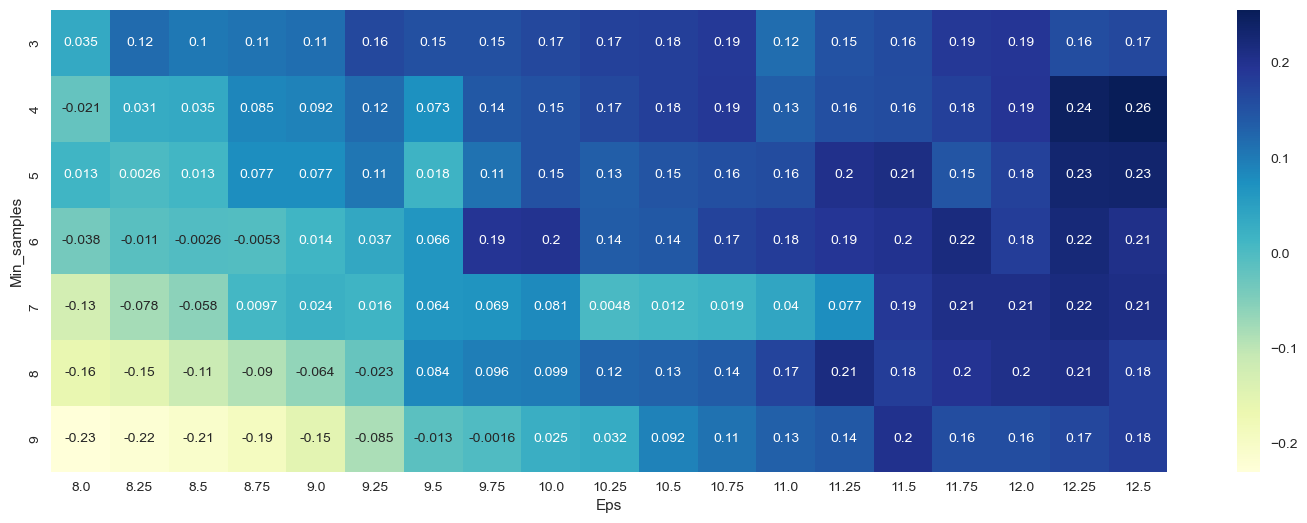

In [36]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

这时候我们可以知道轮廓系数最大值是0.26，对应的`eps`=12.5，`min_samples`是4

检查各个聚类的个数

In [37]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

DBSCAN_size
Cluster             
-1                18
 0               112
 1                 8
 2                34
 3                24
 4                 4

DBSCAN 创建了 5 个聚类以及异常值聚类 (-1)。 聚类 0-4 的大小差异很大 - 有些只有 4 或 8 个观测值。 有 18 个异常值

接下来我们进行作图

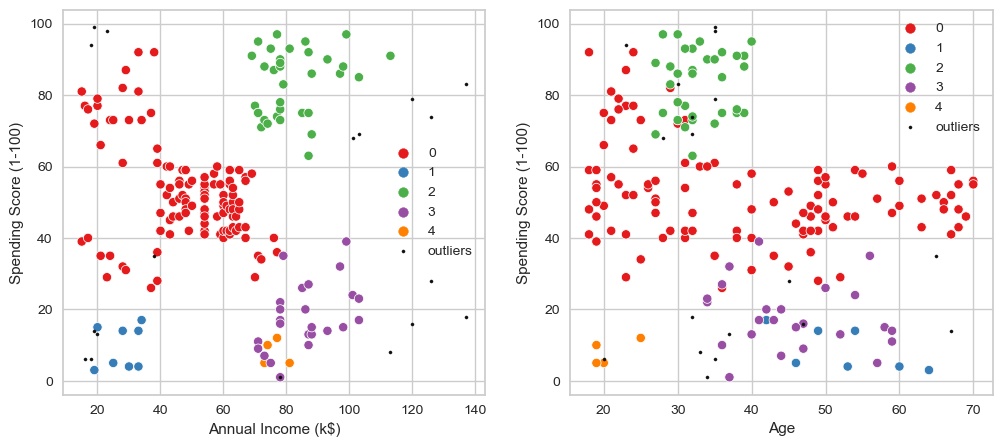

In [38]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

# Affinity Propagation

参考：http://xiaqunfeng.cc/2018/04/08/affinity-propagation/

这个聚类的特点是，初始化标准无敏感性，意思就是不需要随机因子，每一次聚类的结果都是一样的

用户需要指定两个参数：
- 偏好：负数，控制使用多少个样本
- 阻尼因子：防止更新时的数值振荡

In [39]:
from sklearn.cluster import AffinityPropagation

## 选择最佳的偏好值
接下来就从-20000到-5000以100步长，选出具有最大轮廓系数的参数值

In [40]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
    '''
    使用silhouette_score()函数计算亲和传播聚类结果的轮廓系数
    这个函数需要输入数据集X_numerics和聚类结果中的标签AF.labels_
    然后返回相应的轮廓系数，并将其添加到af_sil_score列表中
    '''
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() 

preference  clusters  sil_score
82    -11800.0       6.0   0.451649
27    -17300.0       6.0   0.451491
51    -14900.0       6.0   0.451491
52    -14800.0       6.0   0.451440
28    -17200.0       6.0   0.451440

In [41]:
af_results.T.head()

0             1             2             3    \
preference -20000.000000 -19900.000000 -19800.000000 -19700.000000   
clusters        5.000000      6.000000      6.000000      6.000000   
sil_score       0.445343      0.449693      0.449119      0.446821   

                     4             5            6            7    \
preference -19600.000000 -19500.000000 -19400.00000 -19300.00000   
clusters        6.000000      5.000000      6.00000      6.00000   
sil_score       0.446821      0.443916      0.43862      0.43862   

                     8            9    ...          140          141  \
preference -19200.000000 -19100.00000  ... -6000.000000 -5900.000000   
clusters        5.000000      6.00000  ...     8.000000     9.000000   
sil_score       0.445343      0.43862  ...     0.420604     0.418703   

                    142          143          144          145          146  \
preference -5800.000000 -5700.000000 -5600.000000 -5500.000000 -5400.000000   
clusters       9.000000     9.000000     9.000000     9.000000     9.000000   
sil_score      0.418703     0.418703     0.418703     0.409475     0.409475   

                    147          148          149  
preference -5300.000000 -5200.000000 -5100.000000  
clusters       9.000000     9.000000     9.000000  
sil_score      0.414309     0.414309     0.409475  

[3 rows x 150 columns]

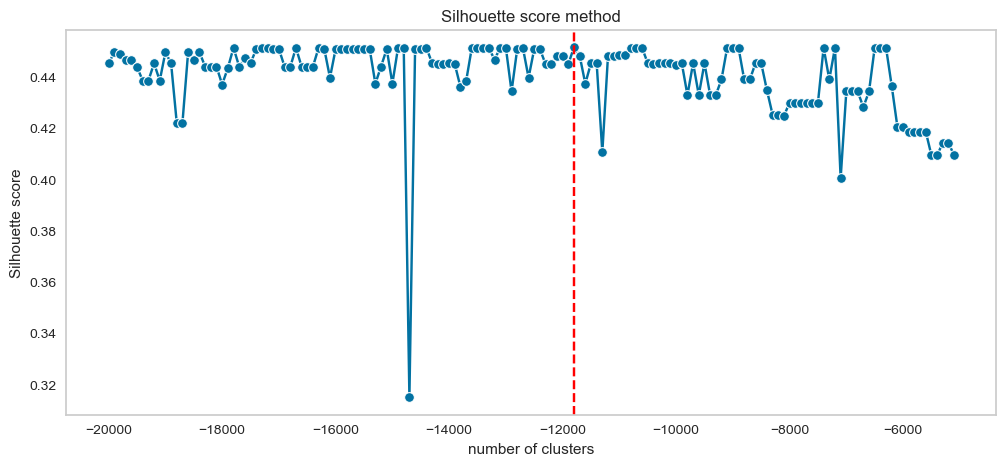

In [43]:
# 作图

fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=preferences, y=af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

## 构建模型

In [44]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [45]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

AF_size
Cluster         
0             22
1             22
2             44
3             39
4             34
5             39

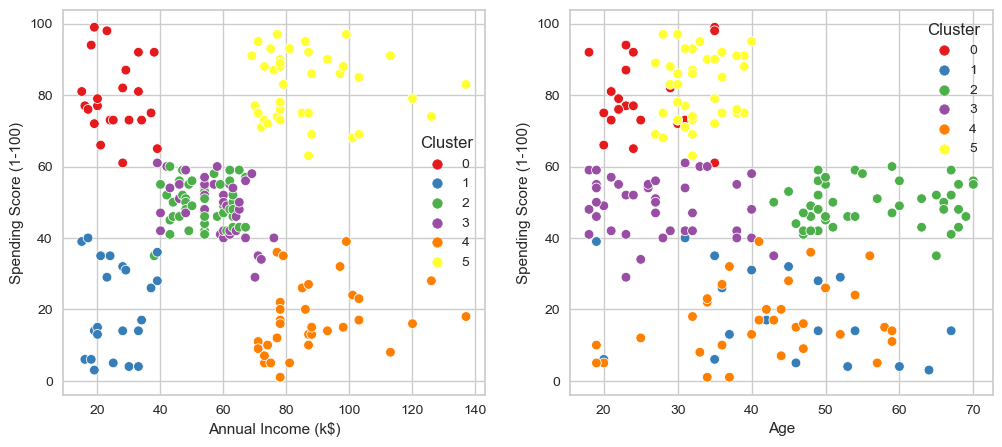

In [48]:
# 作图

fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

# 三种聚类结果的比较


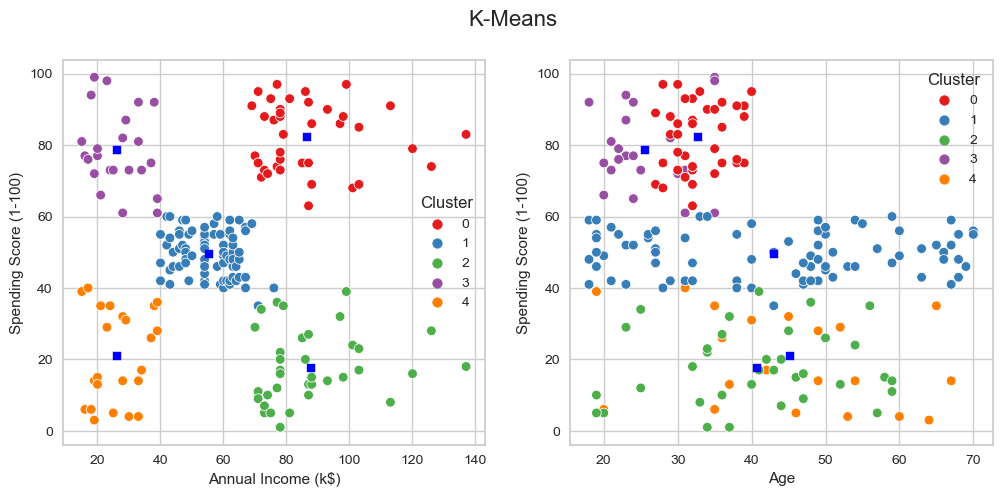

In [49]:
fig1.suptitle('K-Means', fontsize=16)
fig1

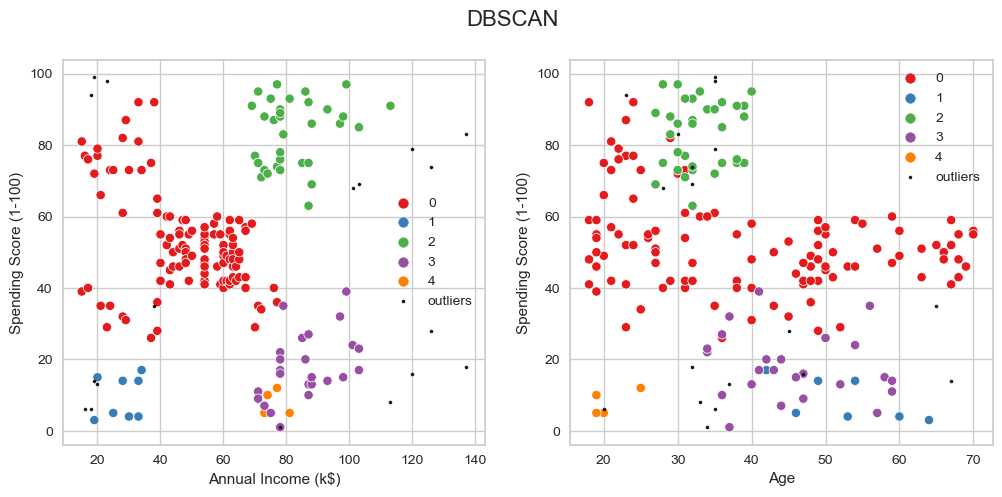

In [51]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

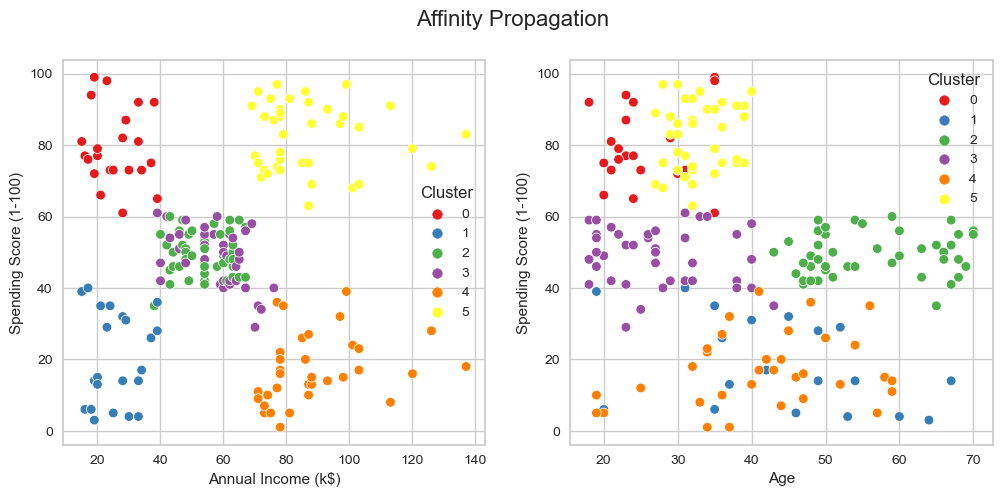

In [52]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

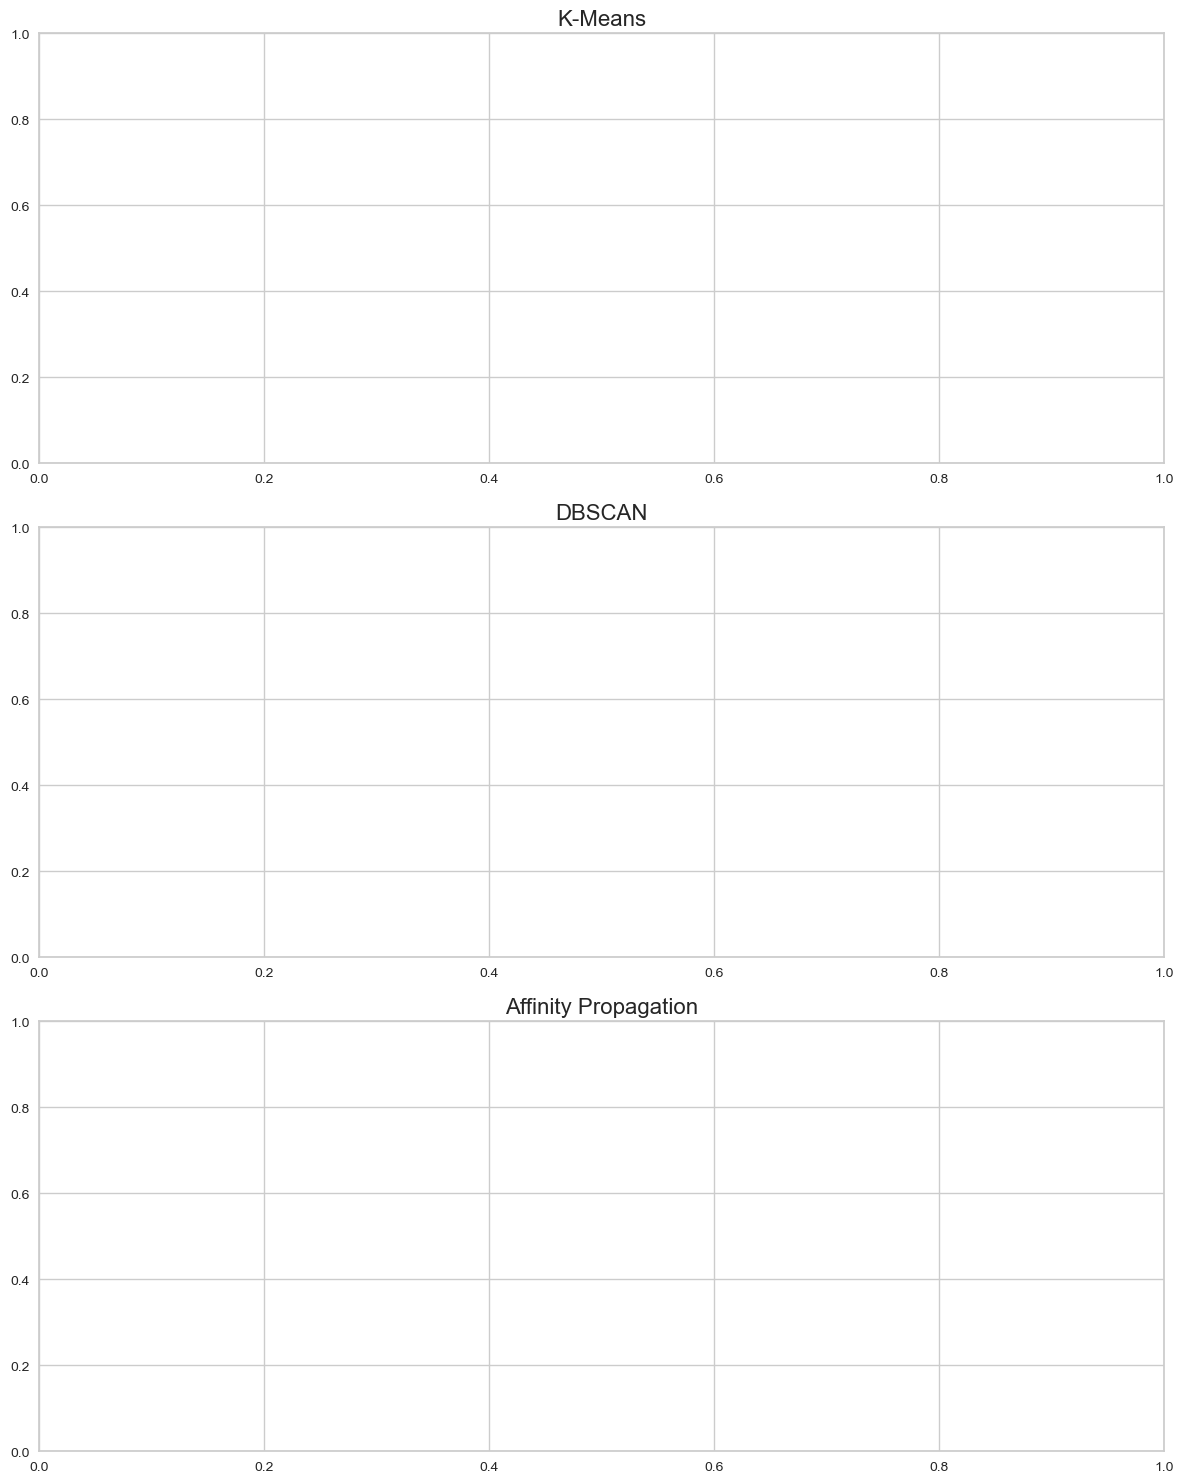